In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [1]:
!pip install deeptrack
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
Layer=keras.layers.Layer
from keras.layers import Dropout, LayerNormalization, Conv1D, Dense
from tensorflow.keras import Model, layers, losses

class Time2Vector(Layer): #Time embedding layer
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    x = tf.math.reduce_mean(x[:,:,:], axis=-1) # Convert (batch, seq_len, 5) to (batch, seq_len)
    time_linear = self.weights_linear * x + self.bias_linear
    time_linear = tf.expand_dims(time_linear, axis=-1) # (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # (batch, seq_len, 2)
  
  def get_config(self):
    conf = super().get_config().copy()
    conf.update({'seq_len': self.seq_len})
    return conf

class SingleAttention(Layer): #Attention layer
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
    self.key = Dense(self.d_k, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
    self.value = Dense(self.d_v, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out 

class MultiAttention(Layer): #Multihead attention
  def __init__(self, d_k, d_v, n_heads,filt_dim):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.filt_dim=filt_dim
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    self.linear = Dense(self.filt_dim, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear

class TransformerEncoder(Layer): #Combining everything into a Transformer encoder
  def __init__(self, d_k, d_v, n_heads, ff_dim,filt_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.filt_dim=filt_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads,self.filt_dim)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    self.ff_conv1D_2 = Conv1D(filters=self.filt_dim, kernel_size=1) # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer

  def get_config(self):
    conf = super().get_config().copy()
    conf.update({'d_k': self.d_k,
                 'd_v': self.d_v,
                 'n_heads': self.n_heads,
                 'ff_dim': self.ff_dim,
                 'filt_dim': self.filt_dim,
                 'attn_heads': self.attn_heads,
                 'dropout_rate': self.dropout_rate})
    return conf

distutils: c:\users\arwin\appdata\local\programs\python\python38\Include\UNKNOWN
sysconfig: c:\users\arwin\appdata\local\programs\python\python38\Include
user = False
home = None
root = None
prefix = None
distutils: c:\users\arwin\appdata\local\programs\python\python38\Include\UNKNOWN
sysconfig: c:\users\arwin\appdata\local\programs\python\python38\Include
user = False
home = None
root = None
prefix = None


In [2]:
import deeptrack as dt
IMAGE_SIZE=64
sequence_length=10#Number of frames per sequence
MIN_SIZE=.5e-6
MAX_SIZE=1.5e-6
MAX_VEL=10 #Maximum velocity. The higher the trickier!
MAX_PARTICLES=3 #Max number of particles in each sequence. The higher the trickier!

#Defining properties of the particles
particle=dt.Sphere(intensity=lambda: 10+10*np.random.rand(),
                   radius=lambda: MIN_SIZE+np.random.rand()*(MAX_SIZE-MIN_SIZE),
                   position=lambda: IMAGE_SIZE*np.random.rand(2),vel=lambda: MAX_VEL*np.random.rand(2),
                   position_unit="pixel")

#Defining an update rule for the particle position
def get_position(previous_value,vel):

    newv=previous_value+vel
    for i in range(2):
        if newv[i]>63:
            newv[i]=63-np.abs(newv[i]-63)
            vel[i]=-vel[i]
        elif newv[i]<0:
            newv[i]=np.abs(newv[i])
            vel[i]=-vel[i]
    return newv

particle=dt.Sequential(particle,position=get_position)

#Defining properties of the microscope
optics=dt.Fluorescence(NA=1,output_region= (0, 0,IMAGE_SIZE, IMAGE_SIZE), 
    magnification=10,
    resolution=(1e-6, 1e-6),
    wavelength=633e-9)

#Combining everything into a dataset. 
#Note that the sequences are flipped in different directions, so that each unique sequence defines
#in fact 8 sequences flipped in different directions, to speed up data generation
dataset=dt.FlipUD(dt.FlipDiagonal(dt.FlipLR(dt.Sequence(optics(particle**(lambda: 1+np.random.randint(MAX_PARTICLES))),sequence_length=sequence_length))))

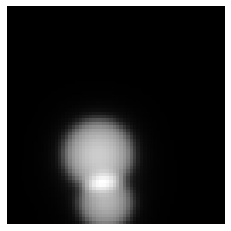

In [3]:
dataset.update().plot(cmap="gray") #This generates a new sequence and plots it
video=dataset.update().resolve() #This generates a new sequence and stores in in "video"

# **Prepare Data**

In [15]:
def generate_tensor_data(data_size):
  images = []

  for _ in range(data_size):
    video = dataset.update().resolve()
    for image in video:
      images.append(image)

  return tf.stack(images)

data_size = 1000
#video_data = generate_tensor_data(data_size)
#np.save('video_data.npy', video_data)


In [16]:
# Load already generated data

video_data = np.load('video_data.npy')

# **Prepare Model**

In [314]:
bottle_size = 512

class AutoEncoder(Model):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1)),
      layers.Conv2D(16, (6, 6), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2),
      layers.Flatten(),
      layers.Dense(bottle_size, activation='linear') # Bottleneck
      ])

    self.decoder = tf.keras.Sequential([
      layers.Reshape(target_shape=(16, 16, 2)),
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=6, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='linear', padding='same', strides=1)])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

auto_encoder = AutoEncoder()

auto_encoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

auto_encoder.encoder.build(input_shape=(None, 64, 64, 1))
auto_encoder.encoder.summary()

auto_encoder.decoder.build(input_shape=(None, bottle_size))
auto_encoder.decoder.summary()



Model: "sequential_404"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_583 (Conv2D)          (None, 32, 32, 16)        592       
_________________________________________________________________
conv2d_584 (Conv2D)          (None, 16, 16, 8)         1160      
_________________________________________________________________
flatten_191 (Flatten)        (None, 2048)              0         
_________________________________________________________________
dense_72 (Dense)             (None, 512)               1049088   
Total params: 1,050,840
Trainable params: 1,050,840
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_405"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_188 (Reshape)        (None, 16, 16, 2)         0         
__________________

In [315]:
n_images = len(video_data)

splits = [int(0.8 * n_images), int(0.2 * n_images)]

train_data, val_data = tf.split(video_data, splits, 0)

print("Shape of Training Data: " + str(train_data.shape))
print("Shape of Validation Data: " + str(val_data.shape))

Shape of Training Data: (8000, 64, 64, 1)
Shape of Validation Data: (2000, 64, 64, 1)


In [316]:
# TRAINING

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            min_delta=0,
                                            patience=3,
                                            verbose=1,
                                            mode='auto',
                                            baseline=None,
                                            restore_best_weights=True)
auto_encoder.fit(train_data, train_data,
                 batch_size=32,
                 epochs=50,
                 shuffle=True,
                 validation_data=(val_data, val_data),
                 callbacks=[callback])

auto_encoder.save('auto_encoder')

Epoch 1/50
250/250 [==============================] - 4s 11ms/step - loss: 11.8245 - val_loss: 0.8275
Epoch 2/50
250/250 [==============================] - 3s 10ms/step - loss: 0.7983 - val_loss: 0.4632
Epoch 3/50
250/250 [==============================] - 3s 10ms/step - loss: 0.4685 - val_loss: 0.3087
Epoch 4/50
250/250 [==============================] - 3s 10ms/step - loss: 0.3262 - val_loss: 0.2655
Epoch 5/50
250/250 [==============================] - 3s 10ms/step - loss: 0.2511 - val_loss: 0.2196
Epoch 6/50
250/250 [==============================] - 3s 10ms/step - loss: 0.2104 - val_loss: 0.1574
Epoch 7/50
250/250 [==============================] - 3s 10ms/step - loss: 0.1660 - val_loss: 0.1414
Epoch 8/50
250/250 [==============================] - 3s 11ms/step - loss: 0.1580 - val_loss: 0.1310
Epoch 9/50
250/250 [==============================] - 3s 11ms/step - loss: 0.1371 - val_loss: 0.1240
Epoch 10/50
250/250 [==============================] - 3s 10ms/step - loss: 0.1204 - val_l

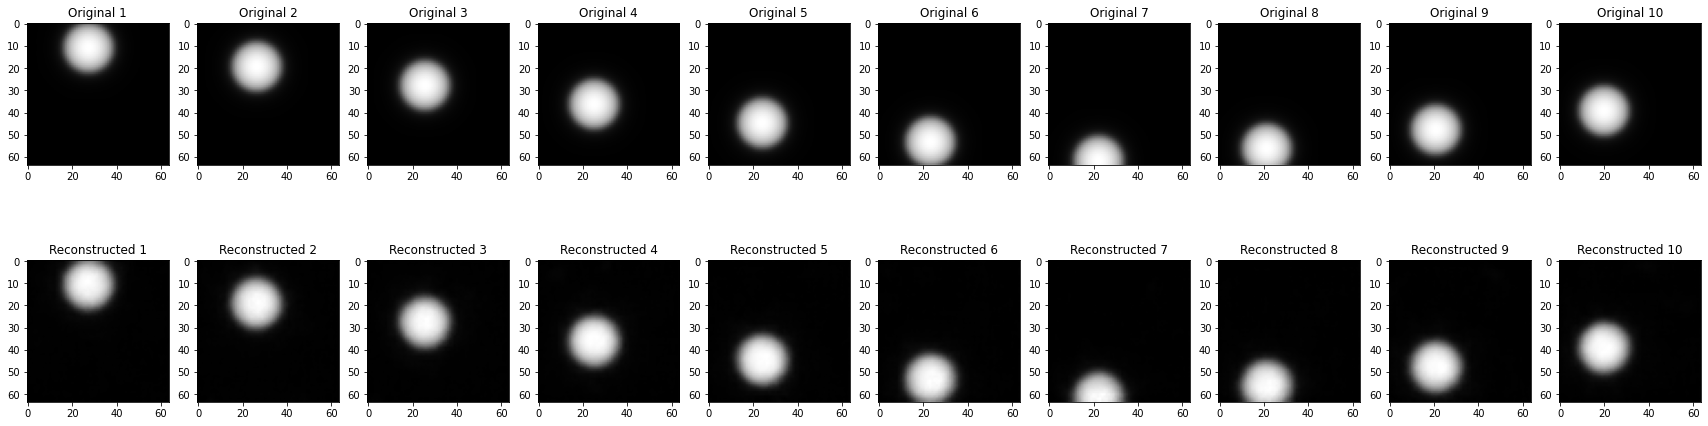

In [318]:
n_disp_img = 10
rand_idx = np.random.randint(len(val_data)/n_disp_img)

idx1 = rand_idx * n_disp_img
idx2 = rand_idx * n_disp_img + n_disp_img

OG_imgs = val_data[idx1 : idx2]

encoded = auto_encoder.encoder(OG_imgs)
decoded = auto_encoder.decoder(encoded)

plt.figure(figsize=(30, 8))

for i in range(n_disp_img):

  plt.subplot(2, n_disp_img, i + 1)
  plt.imshow(tf.squeeze(OG_imgs[i]))
  plt.title('Original ' + str(i + 1))
  plt.gray()

  plt.subplot(2, n_disp_img, i + 1 + n_disp_img)
  plt.imshow(tf.squeeze(decoded[i]))
  plt.title('Reconstructed ' + str(i + 1))
  plt.gray()

  """
  # display bottleneck
  ax = plt.subplot(n_disp_img, n_disp_img, i + 1 + n_disp_img*2)
  plt.imshow(tf.reshape(encoded[i], [16, 32]))
  plt.title("bottleneck")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  """

# **TRANSFORMER**

In [ ]:
latent_dim = 10
d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256
filt_dim = latent_dim+2

In [ ]:
latent_dim = 512

class Transformer(Model):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1)),
      layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2),
      layers.Flatten()
      #layers.Dense(latent_dim)
      ])

    self.decoder = tf.keras.Sequential([
      layers.Reshape(target_shape=(8, 8, 8)),
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='linear', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

auto_encoder = AutoEncoder()

auto_encoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

auto_encoder.encoder.build(input_shape=(None, 64, 64, 1))
auto_encoder.encoder.summary()

auto_encoder.decoder.build(input_shape=(None, latent_dim))
auto_encoder.decoder.summary()


In [ ]:
n_images = len(video_data)

splits = [int(0.8 * n_images), int(0.2 * n_images)]

train_data, val_data = tf.split(video_data, splits, 0)

print("Shape of Training Data: " + str(train_data.shape))
print("Shape of Validation Data: " + str(val_data.shape))

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            min_delta=0,
                                            patience=3,
                                            verbose=1,
                                            mode='auto',
                                            baseline=None,
                                            restore_best_weights=True)
auto_encoder.fit(train_data, train_data,
                 batch_size=32,
                 epochs=50,
                 shuffle=True,
                 validation_data=(val_data, val_data),
                 callbacks=[callback])

auto_encoder.save('auto_encoder')